In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score

In [3]:
data = pd.read_csv('Project/Statistical_Learning/data/creditcard.csv')
x = np.array(data.loc[1:len(data)-1, 'Time'])
y = np.array(data.loc[0:len(data)-2, 'Time'])
data.loc[1:, 'Time'] = x-y
normal = data[data['Class']==0]
anomaly = data[data['Class']==1]

In [429]:
train_normal, test_normal = train_test_split(normal, test_size=0.4, random_state=42)
valid_normal, test_normal = train_test_split(test_normal, test_size=1/2, random_state=42)
train_anomaly, test_anomaly = train_test_split(anomaly, test_size=0.4, random_state=42)
valid_anomaly, test_anomaly = train_test_split(test_anomaly, test_size=1/2, random_state=42)

for x in [train_normal, valid_normal, test_normal, train_anomaly, valid_anomaly, test_anomaly]:
    x.reset_index(drop=True, inplace=True)

print('Normal Train:', train_normal.shape, 
      'Normal Valid:', valid_normal.shape, 
      'Normal Test:', test_normal.shape)
print('Anomaly Train:', train_anomaly.shape, 
      'Anomaly Valid:', valid_anomaly.shape, 
      'Anomaly Test:', test_anomaly.shape)

Normal Train: (170589, 31) Normal Valid: (56863, 31) Normal Test: (56863, 31)
Anomaly Train: (295, 31) Anomaly Valid: (98, 31) Anomaly Test: (99, 31)


In [347]:
train = train_normal.append(train_anomaly).sample(frac=1, random_state=42).reset_index(drop=True)
valid = valid_normal.append(valid_anomaly).sample(frac=1, random_state=42).reset_index(drop=True)
test = test_normal.append(test_anomaly).sample(frac=1, random_state=42).reset_index(drop=True)

In [717]:
from mpl_toolkits.mplot3d import Axes3D

In [712]:
%matplotlib

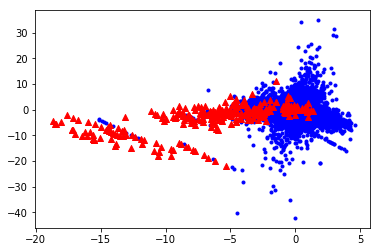

In [722]:
y = train_normal
z = train_anomaly
fig = plt.figure()
ax = fig.add_subplot(111)#, projection='3d')
ax.scatter(y['V12'], y['V5'], c='b', marker='.')
ax.scatter(z['V12'], z['V5'], c='r', marker='^')

plt.show()

C:\Users\LENOVO\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


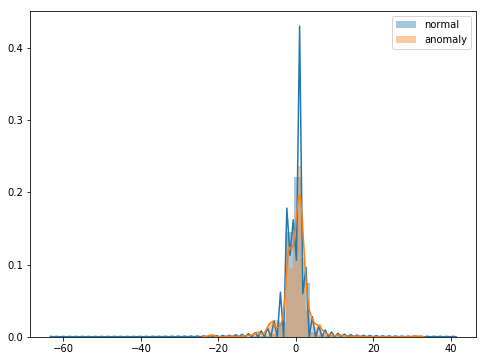

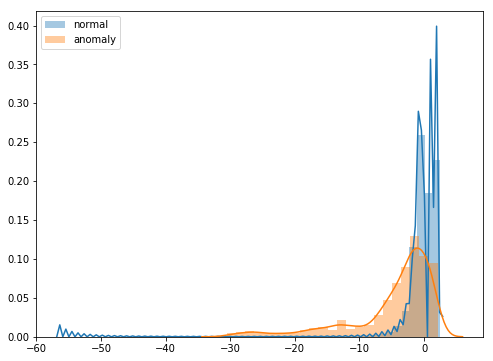

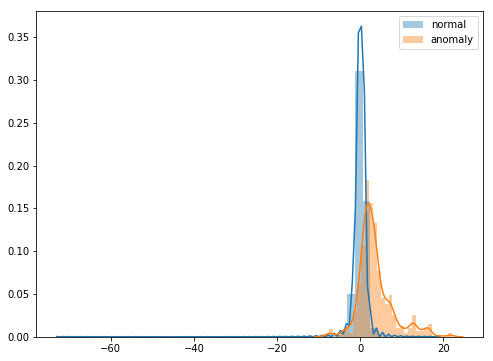

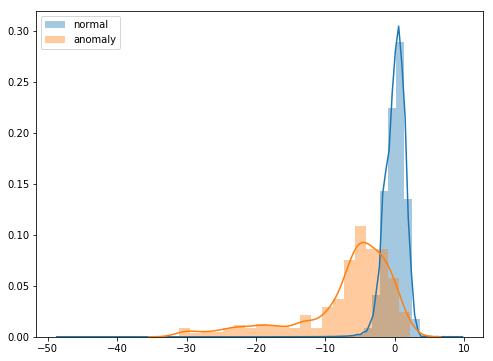

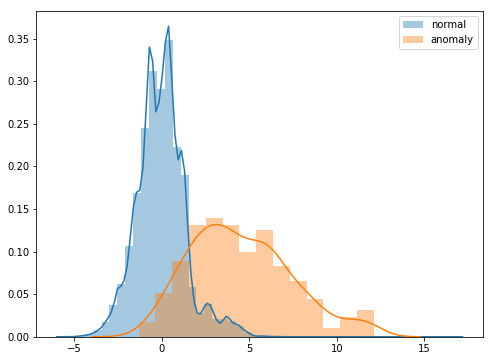

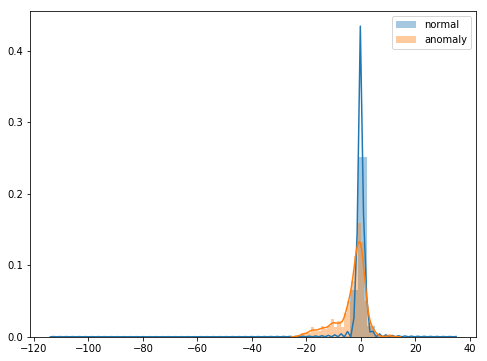

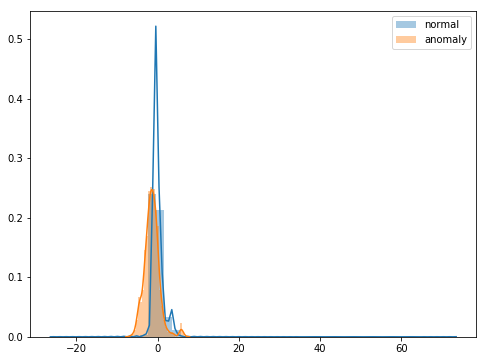

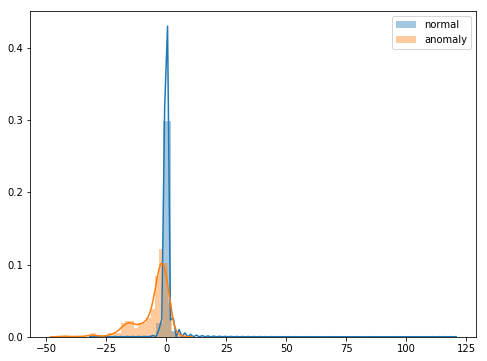

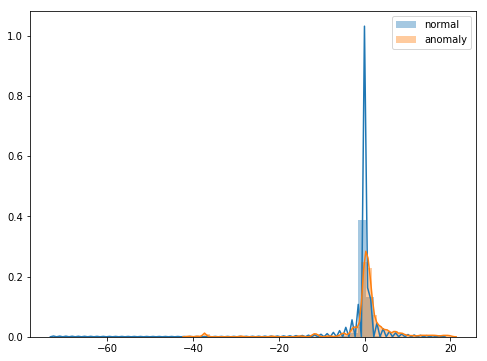

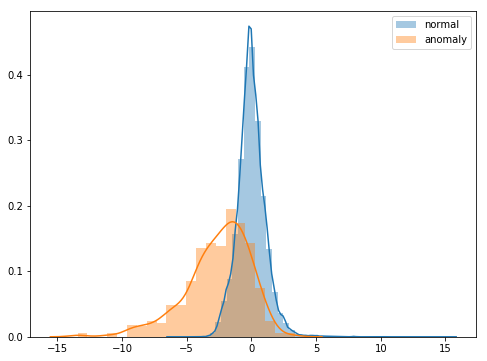

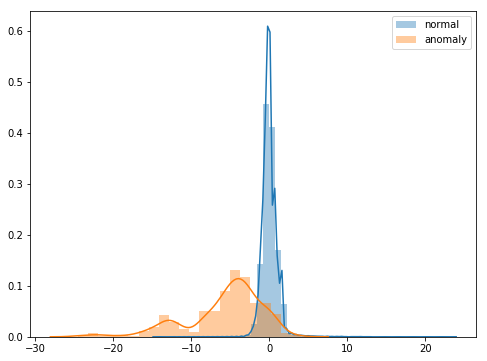

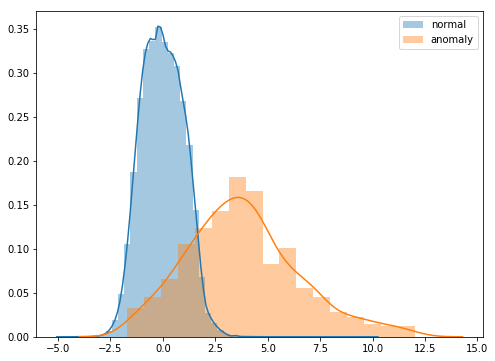

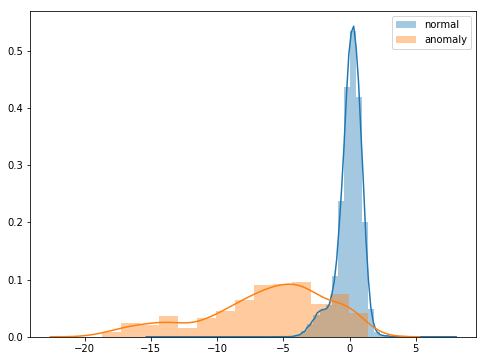

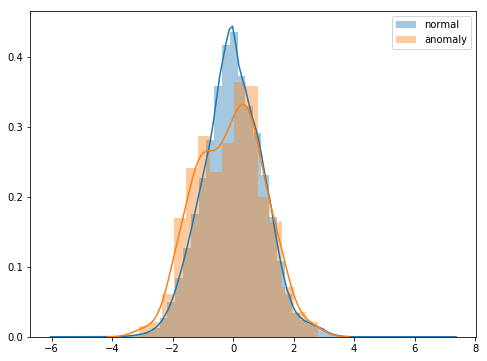

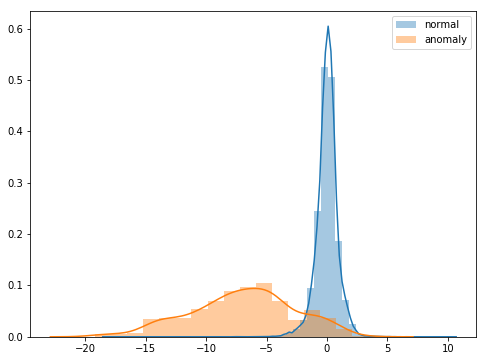

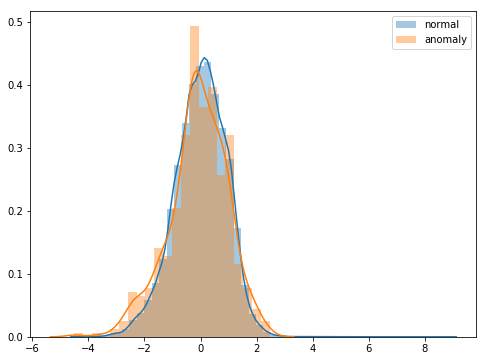

In [164]:
for i in range(len(data.columns)-15):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot()
    sns.distplot(np.array(normal.iloc[:, i]), label='normal', kde=True, norm_hist=False)
    sns.distplot(np.array(anomaly.iloc[:, i]), label='anomaly', kde=True, norm_hist=False)
    plt.legend()

### Gaussian Mixture

In [7]:
from sklearn.mixture import GaussianMixture

In [430]:
gmm_normal = GaussianMixture(n_components=3, n_init=5, max_iter=500, random_state=42, tol=1e-6)
gmm_normal.fit(train_normal.drop(columns=['Class']))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=500,
        means_init=None, n_components=3, n_init=5, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=1e-06, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [431]:
gmm_anomaly = GaussianMixture(n_components=3, n_init=5, max_iter=500, random_state=42, tol=1e-5)
gmm_anomaly.fit(train_anomaly.drop(columns=['Class']))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=500,
        means_init=None, n_components=3, n_init=5, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=1e-05, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [420]:
print(gmm_normal.score(train[train['Class']==0].drop(columns=['Class'])))
print(gmm_normal.score(train[train['Class']==1].drop(columns=['Class'])))
print(gmm_anomaly.score(train[train['Class']==0].drop(columns=['Class'])))
print(gmm_anomaly.score(train[train['Class']==1].drop(columns=['Class'])))

-10.721976083317271
-412810.6979944631
-188.42825514585115
-40.7585530818824


In [396]:
x = valid

tune = np.linspace(250, 750, 501)
score = []
for p in tune:
    predict_gmm = (p + gmm_normal.score_samples(x.drop(columns=['Class'])) <= gmm_anomaly.score_samples(x.drop(columns=['Class']))).astype(np.int32)
    predict = predict_gmm
    recall_gmm = recall_score(y_true=x['Class'].values, y_pred=predict)
    precision_gmm = precision_score(y_true=x['Class'].values, y_pred=predict)
    fbeta_gmm = fbeta_score(y_true=x['Class'].values, y_pred=predict, beta=1)
    score.append([recall_gmm, precision_gmm, fbeta_gmm])

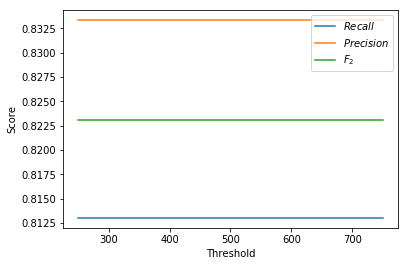

In [397]:
score = np.array(score)
plt.plot(tune, score[:, 0], label='$Recall$')
plt.plot(tune, score[:, 1], label='$Precision$')
plt.plot(tune, score[:, 2], label='$F_2$')
plt.ylabel('Score')
# plt.xticks(np.logspace(-10, -200, 3))
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [398]:
tune[score[:, 2].argmax()]

250.0

In [427]:
x = test

p = 750
predict_gmm = (p + gmm_normal.score_samples(x.drop(columns=['Class'])) <= gmm_anomaly.score_samples(x.drop(columns=['Class']))).astype(np.int32)
predict = predict_gmm

recall_gmm = recall_score(y_true=x['Class'].values, y_pred=predict)
precision_gmm = precision_score(y_true=x['Class'].values, y_pred=predict)
fbeta_gmm = fbeta_score(y_true=x['Class'].values, y_pred=predict, beta=1)

print('Recall:', recall_gmm, '\nPrecision:', precision_gmm, '\nF-score:', fbeta_gmm)

cnf_matrix_gmm = confusion_matrix(y_true=x['Class'].values, y_pred=predict)
cnf_matrix_gmm

Recall: 0.7804878048780488 
Precision: 0.8421052631578947 
F-score: 0.810126582278481


array([[71061,    18],
       [   27,    96]], dtype=int64)

- Model normal data only

In [39]:
x = valid

tune = np.linspace(-3500, 1500, 501)
score = []
for p in tune:
    predict_gmm = (gmm_normal.score_samples(x.drop(columns=['Class'])) <= p).astype(np.int32)
    predict = predict_gmm
    recall_gmm = recall_score(y_true=x['Class'].values, y_pred=predict)
    precision_gmm = precision_score(y_true=x['Class'].values, y_pred=predict)
    fbeta_gmm = fbeta_score(y_true=x['Class'].values, y_pred=predict, beta=1)
    score.append([recall_gmm, precision_gmm, fbeta_gmm])

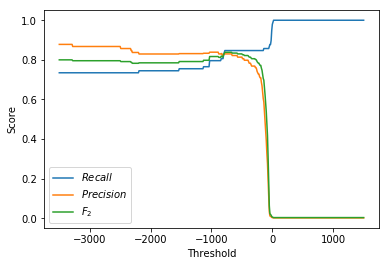

In [40]:
score = np.array(score)
plt.plot(tune, score[:, 0], label='$Recall$')
plt.plot(tune, score[:, 1], label='$Precision$')
plt.plot(tune, score[:, 2], label='$F_2$')
plt.ylabel('Score')
# plt.xticks(np.logspace(-10, -200, 3))
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [41]:
tune[score[:, 2].argmax()]

-780.0

In [341]:
x = test

p = -780
predict_gmm = (gmm_normal.score_samples(x.drop(columns=['Class'])) <= p).astype(np.int32)
predict = predict_gmm

recall_gmm = recall_score(y_true=x['Class'].values, y_pred=predict)
precision_gmm = precision_score(y_true=x['Class'].values, y_pred=predict)
fbeta_gmm = fbeta_score(y_true=x['Class'].values, y_pred=predict, beta=2)

print('Recall:', recall_gmm, '\nPrecision:', precision_gmm, '\nF-score:', fbeta_gmm)

cnf_matrix_gmm = confusion_matrix(y_true=x['Class'].values, y_pred=predict)
cnf_matrix_gmm

Recall: 0.7905405405405406 
Precision: 0.8297872340425532 
F-score: 0.7980900409276944


array([[85271,    24],
       [   31,   117]], dtype=int64)

0.9401529295755541
0.9385116777770572
0.6201802025617437


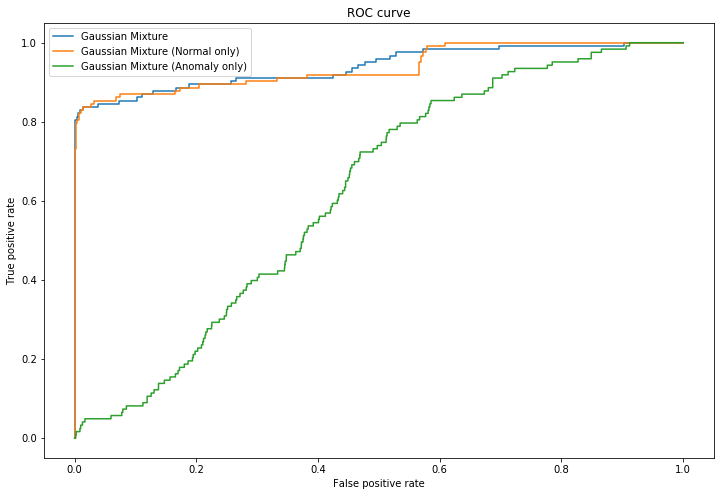

In [355]:
fig = plt.figure(figsize=(12, 8))

x = test

pred = - gmm_normal.score_samples(x.drop(columns=['Class'])) + gmm_anomaly.score_samples(x.drop(columns=['Class']))
fpr, tpr, thresholds = roc_curve(y_true=x['Class'], y_score=pred)
print(roc_auc_score(y_true=x['Class'], y_score=pred))
plt.plot(fpr, tpr, label='Gaussian Mixture')

pred = - gmm_normal.score_samples(x.drop(columns=['Class']))
fpr, tpr, thresholds = roc_curve(y_true=x['Class'], y_score=pred)
print(roc_auc_score(y_true=x['Class'], y_score=pred))
plt.plot(fpr, tpr, label='Gaussian Mixture (Normal only)')

pred = gmm_anomaly.score_samples(x.drop(columns=['Class']))
fpr, tpr, thresholds = roc_curve(y_true=x['Class'], y_score=pred)
print(roc_auc_score(y_true=x['Class'], y_score=pred))
plt.plot(fpr, tpr, label='Gaussian Mixture (Anomaly only)')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Local Outlier Factor

- Model normal data only
- Tuning Parameters: n_neighbors, contamination

In [ ]:
from sklearn.ensemble import IsolationForest

In [323]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=100, novelty=True, contamination=0.0005).fit(normal_train.drop(columns=['Class']))

In [222]:
pre = lof.predict(normal_valid.drop(columns=['Class']))

sum(1+pre)/2, len(pre)

(28380.0, 28431)

In [470]:
pre = lof.predict(anomaly_valid.drop(columns=['Class']))

sum(1-pre)/2, len(pre)

(26.0, 49)

- Model mixed data
- Set comtamination to the proportion of anomaly data
- Tuning Parameters: n_neighbors

In [237]:
neighbors = 100
m = train['Class'].mean()

lof = LocalOutlierFactor(n_neighbors=neighbors, novelty=True, contamination=m).fit(train.drop(columns=['Class']))

In [266]:
x = valid

In [267]:
predict_lof = lof.predict(x.drop(columns=['Class']))

predict = (1-predict_lof)//2

In [269]:
recall_lof = recall_score(y_true=x['Class'].values, y_pred=predict)
precision_lof = precision_score(y_true=x['Class'].values, y_pred=predict)
fbeta_lof = fbeta_score(y_true=x['Class'].values, y_pred=predict, beta=2)

print('Recall:', recall_lof, '\nPrecision:', precision_lof, '\nF-score:', fbeta_lof)

cnf_matrix_lof = confusion_matrix(y_true=x['Class'].values, y_pred=predict)
cnf_matrix_lof

Recall: 0.22 
Precision: 0.22 
F-score: 0.22


array([[28393,    39],
       [   39,    11]], dtype=int64)

### Isolation Forest

In [667]:
ilf = IsolationForest(n_estimators=50, contamination=0.001, behaviour='new').fit(normal_train.drop(columns=['Class']))

In [320]:
x = valid

predict_ilf = ilf.predict(x.drop(columns=['Class']))

predict = (1-predict_ilf)//2

In [322]:
recall_ilf = recall_score(y_true=x['Class'].values, y_pred=predict)
precision_ilf = precision_score(y_true=x['Class'].values, y_pred=predict)
fbeta_ilf = fbeta_score(y_true=x['Class'].values, y_pred=predict, beta=2)

print('Recall:', recall_ilf, '\nPrecision:', precision_ilf, '\nF-score:', fbeta_ilf)

cnf_matrix_ilf = confusion_matrix(y_true=x['Class'].values, y_pred=predict)
cnf_matrix_ilf

Recall: 0.37150127226463103 
Precision: 1.0 
F-score: 0.42491268917345754


array([[  0,   0],
       [247, 146]], dtype=int64)

In [63]:
pre = ilf.predict(anomaly)

sum(1-pre)/2/len(pre)

0.9004065040650406

In [292]:
estimators = 50
m = train['Class'].mean()

ilf = IsolationForest(n_estimators=estimators, contamination=m, behaviour='new').fit(train.drop(columns=['Class']))

In [293]:
x = valid

predict_ilf = ilf.predict(x.drop(columns=['Class']))

predict = (1-predict_ilf)//2

In [295]:
recall_ilf = recall_score(y_true=x['Class'].values, y_pred=predict)
precision_ilf = precision_score(y_true=x['Class'].values, y_pred=predict)
fbeta_ilf = fbeta_score(y_true=x['Class'].values, y_pred=predict, beta=2)

print('Recall:', recall_ilf, 'Precision:', precision_ilf, 'F-score:', fbeta_ilf)

cnf_matrix_ilf = confusion_matrix(y_true=x['Class'].values, y_pred=predict)
cnf_matrix_ilf

Recall: 0.2857142857142857 Precision: 0.4 F-score: 0.30303030303030304


array([[28410,    21],
       [   35,    14]], dtype=int64)

### One Class SVM

In [70]:
from sklearn.svm import OneClassSVM

ocs = OneClassSVM().fit(normal[:50000])

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [71]:
pre = ocs.predict(normal[50000:100000])

sum(1+pre)/2/len(pre)

0.53242

In [72]:
pre = ocs.predict(anomaly)

sum(1-pre)/2/len(pre)

0.9715447154471545

In [93]:
91/103

0.883495145631068